# USMC - Calibration












In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [63]:
sector_categories = {
    'Primary': ['Agriculture', 'Fishing', 'Mining and Quarrying''Food & Beverages', 
                       'Textiles and Wearing Apparel', 'Wood and Paper',
                       'Petroleum, Chemical and Non-Metallic Mineral Products'],
    
    'Secondary': ['Metal Products','Electrical and Machinery', 'Transport Equipment', 
                                    'Other Manufacturing', 'Recycling','Electricity, Gas and Water', 'Construction'],
    'Tertiary': ['Maintenance and Repair','Wholesale Trade', 'Retail Trade', 'Hotels and Restaurants', 'Transport',
                                   'Post and Telecommunications', 'Financial Intermediation and Business Activities',
                                   'Public Administration', 'Education, Health and Other Services']}

range_year = range(2000,2022)
for year in range_year:
    T = pd.read_csv('/rds/general/user/nk821/home/anaconda3/CCS/EnvMRIO/EORA/EORA/T_{}.csv'.format(year), index_col=[0,1], header=[0,1])
    Y = pd.read_csv('/rds/general/user/nk821/home/anaconda3/CCS/EnvMRIO/EORA/EORA/Y_{}.csv'.format(year), index_col=[0,1], header=[0,1])
    Y_new = Y.reset_index().rename(columns={'1':'iso_code','3':'sector'})
    Y_new = Y_new.set_index(['iso_code','sector'])
    Y_new = Y_new.T.reset_index().rename(columns={'1':'iso_code','3':'sector'})
    Y_new = Y_new.set_index(['iso_code','sector'])
    Y_new = Y_new.T
    Y_new = Y_new.groupby(axis=1,level=0).sum()

    # Create a new column in your DataFrame for the sector category
    Y_new['Sector'] = Y_new.index.get_level_values('sector').map(
        {sector: category for category, sectors in sector_categories.items() for sector in sectors}
    )

    # Sum the values for each country and sector category
    Y_new = Y_new.groupby(['iso_code', 'Sector']).sum()


    T_new = T.reset_index().rename(columns={'1':'iso_code','3':'sector'})
    T_new = T_new.set_index(['iso_code','sector'])
    T_new = T_new.T.reset_index().rename(columns={'1':'iso_code','3':'sector'})
    T_new = T_new.set_index(['iso_code','sector'])

    # Create a new column in your DataFrame for the sector category
    T_new['Sector'] = T_new.index.get_level_values('sector').map(
        {sector: category for category, sectors in sector_categories.items() for sector in sectors}
    )

    # Sum the values for each country and sector category
    T_new = T_new.groupby(['iso_code', 'Sector']).sum()
    T_new = T_new.T
    # Create a new column in your DataFrame for the sector category
    T_new['Sector'] = T_new.index.get_level_values('sector').map(
        {sector: category for category, sectors in sector_categories.items() for sector in sectors}
    )

    # Sum the values for each country and sector category
    T_new = T_new.groupby(['iso_code', 'Sector']).sum()
    T_new=T_new.T

    usmc_countries = ['USA', 'MEX', 'CAN']

    T_usmc = T_new.loc[(usmc_countries, slice(None)), (usmc_countries, slice(None))]
    T_usmc = T_usmc.groupby(axis=1, level=0).sum()
    T_usmc = T_usmc.rename(columns={'iso_code':'Group'})
    T_usmc = T_usmc[['USA', 'MEX','CAN']]

    Y_usmc = Y_new.loc[(usmc_countries, slice(None)), (usmc_countries)]
    Y_usmc = Y_usmc[['USA', 'MEX','CAN']]
    TY_USMC = T_usmc + Y_usmc
    TY_USMC = TY_USMC.reset_index()
    TY_USMC = TY_USMC.rename(columns={'iso_code':'Group','USA':0,'MEX':1,'CAN':2})
    
#     TY_USMC = TY_USMC.drop(['iso_code'], axis=1)
    TY_USMC['Group'] = TY_USMC['Group'].map({'USA':0, 'MEX':1, 'CAN':2})
    TY_USMC['Sector']= TY_USMC['Sector'].map({'Primary':1,'Secondary':2, 'Tertiary':3})
    
    TY_USMC = TY_USMC[TY_USMC.Sector !=3]
#     TY_USMC = TY_USMC.reset_index()
#     print(TY_USMC)

    TY_USMC.to_csv('/rds/general/user/nk821/home/anaconda3/CCS/ABM/Gulden/vectorised_tests/IO_mats/Data/TY_USMC_{}.csv'.format(year))

## Model 1 - 2021

### Optimisation Results

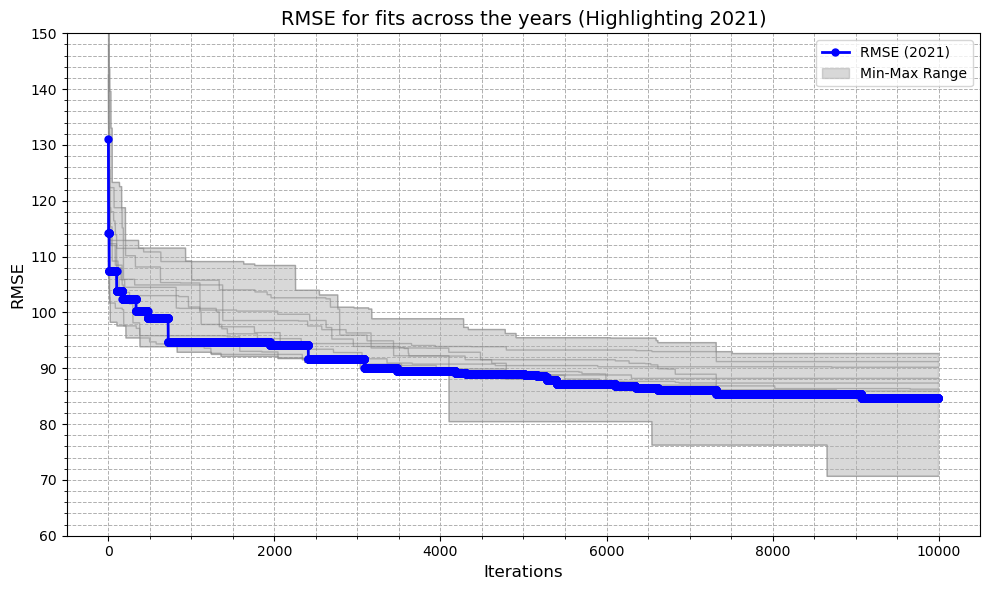

In [32]:
import pickle
import matplotlib.pyplot as plt

years = list(range(2012, 2022))
rmse_data = {}

# Load RMSE data for all years
for year in years:
    with open('/rds/general/user/nk821/home/anaconda3/CCS/ABM/Gulden/vectorised_tests/IO_mats/jobs/opt_results/optimization_results_{}.pkl'.format(year), 'rb') as f:
        log = pickle.load(f)
        rmse_data[year] = np.sqrt(np.array(log['NGOpt']))

    
# Convert the results to a 2D array for easier processing
all_rmse = np.array([rmse_data[year] for year in years])

# Calculate the min and max across all years (for the shaded region)
min_rmse = np.min(all_rmse, axis=0)
max_rmse = np.max(all_rmse, axis=0)

# Plotting
plt.figure(figsize=(10, 6))

# Plot RMSE for each year in grey except 2021
for year in years:
    if year != 2021:
        plt.plot(rmse_data[year], color='grey', linewidth=1, alpha=0.5)

# Highlight 2021 in a different color
plt.plot(rmse_data[2021], color='blue', linewidth=2, marker='o', markersize=5, label='RMSE (2021)')

# Plot the shaded region (min-max range)
plt.fill_between(range(len(rmse_data[2021])), min_rmse, max_rmse, color='grey', alpha=0.3, label='Min-Max Range')

# Add labels and title
plt.title('RMSE for fits across the years (Highlighting 2021)', fontsize=14)
plt.xlabel('Iterations', fontsize=12)
plt.ylabel('RMSE', fontsize=12)
plt.ylim([60,150])
# plt.yscale('log')
# Improve the grid and layout
plt.grid(True, which='both', linestyle='--', linewidth=0.7)
plt.minorticks_on()

# Add the legend
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

In [15]:
beta_log

{'NGOpt': array([[0.6411309 , 0.33461819, 0.45381897],
        [0.58960897, 0.69578004, 0.50164927],
        [0.17146573, 0.3444221 , 0.16735652]])}

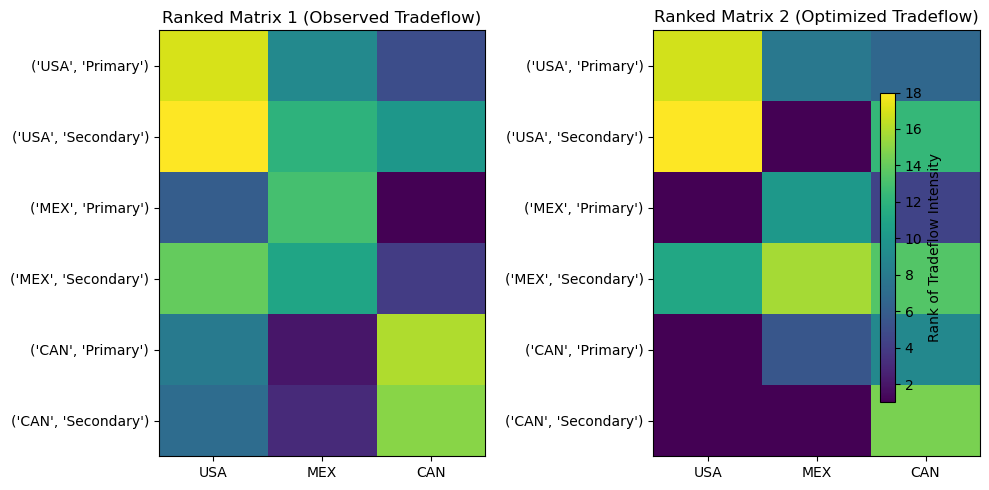

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import rankdata

# Creating the two dataframes from the provided data
data1 = pd.DataFrame({
    'USA': [1613.213548, 1784.097582, 30.819201, 92.850262, 56.533431, 53.591285],
    'MEX': [62.880863, 81.082130, 86.200590, 75.139430, 1.923035, 2.911639],
    'CAN': [25.746963, 64.806347, 0.661584, 4.607973, 227.435692, 190.632179]
}, index=[('USA', 'Primary'), ('USA', 'Secondary'), ('MEX','Primary' ), ('MEX', 'Secondary'), ('CAN', 'Primary'), ('CAN',  'Secondary')])

data2 = pd.DataFrame({
    'USA': [931.825251, 2925.367832, 0.0, 88.661489, 0.0, 0.0],
    'MEX': [28.363929, 0.0, 44.307819, 224.245705, 0.223381, 0.0],
    'CAN': [24.487877, 90.458598, 0.083409, 109.980769, 38.156407, 202.695390]
}, index=[('USA', 'Primary'), ('USA', 'Secondary'), ('MEX','Primary' ), ('MEX', 'Secondary'), ('CAN', 'Primary'), ('CAN',  'Secondary')])

# Step 1: Flatten both matrices and rank their values
ranked_data1 = rankdata(data1.values.flatten()).reshape(data1.shape)
ranked_data2 = rankdata(data2.values.flatten()).reshape(data2.shape)

# Step 2: Plot using imshow with ranks
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# Plot ranked Matrix 1 (Observed Tradeflow)
im1 = ax[0].imshow(ranked_data1, cmap='viridis', aspect='auto')
ax[0].set_title('Ranked Matrix 1 (Observed Tradeflow)')
ax[0].set_xticks(np.arange(data1.shape[1]))
ax[0].set_yticks(np.arange(len(data1.index)))
ax[0].set_xticklabels(data1.columns)
ax[0].set_yticklabels(data1.index)

# Plot ranked Matrix 2 (Optimized Tradeflow)
im2 = ax[1].imshow(ranked_data2, cmap='viridis', aspect='auto')
ax[1].set_title('Ranked Matrix 2 (Optimized Tradeflow)')
ax[1].set_xticks(np.arange(data2.shape[1]))
ax[1].set_yticks(np.arange(len(data2.index)))
ax[1].set_xticklabels(data2.columns)
ax[1].set_yticklabels(data2.index)

# Step 3: Add a colorbar to show the color scale
cbar = fig.colorbar(im1, ax=ax, orientation='vertical', fraction=0.02, pad=0.04)
cbar.set_label('Rank of Tradeflow Intensity')

plt.tight_layout()
plt.show()


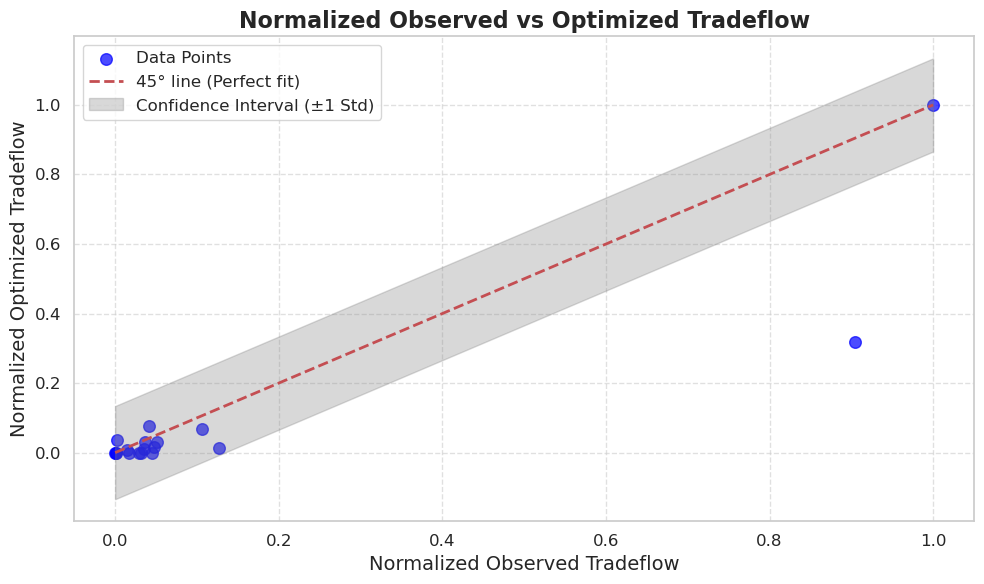

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set a seaborn style for better aesthetics
sns.set(style="whitegrid")

# Creating the two dataframes from the provided data
data1 = pd.DataFrame({
    'USA': [1613.213548, 1784.097582, 30.819201, 92.850262, 56.533431, 53.591285],
    'MEX': [62.880863, 81.082130, 86.200590, 75.139430, 1.923035, 2.911639],
    'CAN': [25.746963, 64.806347, 0.661584, 4.607973, 227.435692, 190.632179]
}, index=[('USA', 'Primary'), ('USA', 'Secondary'), ('MEX', 'Primary'), ('MEX', 'Secondary'), ('CAN', 'Primary'), ('CAN', 'Secondary')])

data2 = pd.DataFrame({
    'USA': [931.825251, 2925.367832, 0.0, 88.661489, 0.0, 0.0],
    'MEX': [28.363929, 0.0, 44.307819, 224.245705, 0.223381, 0.0],
    'CAN': [24.487877, 90.458598, 0.083409, 109.980769, 38.156407, 202.695390]
}, index=[('USA', 'Primary'), ('USA', 'Secondary'), ('MEX', 'Primary'), ('MEX', 'Secondary'), ('CAN', 'Primary'), ('CAN', 'Secondary')])

# Flatten the observed and optimized data
observed = data1.values.flatten()
optimized = data2.values.flatten()

# Step 1: Normalize the values using min-max normalization
obs_min, obs_max = observed.min(), observed.max()
opt_min, opt_max = optimized.min(), optimized.max()

observed_normalized = (observed - obs_min) / (obs_max - obs_min)
optimized_normalized = (optimized - opt_min) / (opt_max - opt_min)

# Step 2: Calculate the residuals and standard deviation for confidence intervals
residuals = observed_normalized - optimized_normalized
std_residuals = np.std(residuals)

# Define the 45-degree line (perfect fit)
x_line = np.linspace(0, 1, 100)
y_line = x_line

# Define the confidence band (1 standard deviation around the 45-degree line)
confidence_upper = y_line + std_residuals
confidence_lower = y_line - std_residuals

# Step 3: Plot normalized scatter plot, confidence interval band, and error metrics
plt.figure(figsize=(10, 6))

# Scatter plot with normalized values
plt.scatter(observed_normalized, optimized_normalized, label='Data Points', color='blue', s=70, alpha=0.7)

# Plot the 45-degree line (perfect fit)
plt.plot(x_line, y_line, 'r--', label='45° line (Perfect fit)', linewidth=2)

# Fill the confidence interval (±1 standard deviation)
plt.fill_between(x_line, confidence_lower, confidence_upper, color='gray', alpha=0.3, label='Confidence Interval (±1 Std)')

# Beautify the plot
plt.title('Normalized Observed vs Optimized Tradeflow', fontsize=16, weight='bold')
plt.xlabel('Normalized Observed Tradeflow', fontsize=14)
plt.ylabel('Normalized Optimized Tradeflow', fontsize=14)

# Customize ticks and axis limits
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
# plt.xlim([0, 1])
# plt.ylim([0, 1])

# Add grid and legend
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(loc='upper left', fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()


## Model 2 - 2021

In [14]:
data2

,USA,MEX,CAN
"(USA, Primary)",931.825251,28.363929,24.487877
"(USA, Secondary)",2925.367832,0.000000,90.458598
"(MEX, Primary)",0.000000,44.307819,0.083409
"(MEX, Secondary)",88.661489,224.245705,109.980769
"(CAN, Primary)",0.000000,0.223381,38.156407
"(CAN, Secondary)",0.000000,0.000000,202.695390


## Model 1 - 2000

In [4]:
# Transactions Table
T = pd.read_csv('/rds/general/user/nk821/home/anaconda3/CCS/EnvMRIO/EORA/T_2000.csv', index_col=[0,1], header=[0,1])
T_new = T.reset_index().rename(columns={'1':'iso_code','3':'sector'})
T_new = T_new.set_index(['iso_code','sector'])
T_new = T_new.T.reset_index().rename(columns={'1':'iso_code','3':'sector'})
T_new = T_new.set_index(['iso_code','sector'])
T_new = T_new.T

# Assuming df is your original DataFrame with multi-index
df = T_new
# Define the new sector categories
sector_categories = {
    'Primary': ['Agriculture', 'Fishing', 'Mining and Quarrying''Food & Beverages', 
                       'Textiles and Wearing Apparel', 'Wood and Paper',
                       'Petroleum, Chemical and Non-Metallic Mineral Products'],
    
    'Secondary': ['Metal Products','Electrical and Machinery', 'Transport Equipment', 
                                    'Other Manufacturing', 'Recycling','Electricity, Gas and Water', 'Construction'],
    
    'Tertiary': ['Maintenance and Repair','Wholesale Trade', 'Retail Trade', 'Hotels and Restaurants', 'Transport',
                                   'Post and Telecommunications', 'Financial Intermediation and Business Activities',
                                   'Public Administration', 'Education, Health and Other Services']
# #     'Transportation and Infrastructure': ['Transport'],
#     'Others': ['Private Households', 'Re-export & Re-import', 'TOTAL', 'Others']
}

# Create a new column in your DataFrame for the sector category
df['Sector'] = df.index.get_level_values('sector').map(
    {sector: category for category, sectors in sector_categories.items() for sector in sectors}
)

# Sum the values for each country and sector category
df = df.groupby(['iso_code', 'Sector']).sum()
df = df.T
# Create a new column in your DataFrame for the sector category
df['Sector'] = df.index.get_level_values('sector').map(
    {sector: category for category, sectors in sector_categories.items() for sector in sectors}
)

# Sum the values for each country and sector category
df = df.groupby(['iso_code', 'Sector']).sum()
df=df.T

# df.to_csv('/rds/general/user/nk821/home/anaconda3/CCS/ABM/Gulden/vectorised_tests/IO_3sectors.csv')
usmc_countries = ['USA', 'MEX', 'CAN']
df_usmc = df.loc[(usmc_countries, slice(None)), (usmc_countries, slice(None))]
# df_usmc.to_csv('/rds/general/user/nk821/home/anaconda3/CCS/ABM/Gulden/vectorised_tests/IO_USMC_3sectors.csv')
df_usmc = df_usmc.groupby(axis=1, level=0).sum()
df_usmc = df_usmc.rename(columns={'iso_code':'Group'})
df_usmc = df_usmc[['USA', 'MEX','CAN']]
df_usmc.to_csv('/rds/general/user/nk821/home/anaconda3/CCS/ABM/Gulden/vectorised_tests/IO_cal_USMC_3sectors_ps_un_2000.csv')
df_usmc

iso_code                     USA           MEX           CAN
iso_code Sector                                             
USA      Primary    8.499975e+08  2.251318e+07  2.081477e+07
         Secondary  1.051053e+09  3.809668e+07  5.393407e+07
         Tertiary   1.143994e+09  1.088884e+06  5.353843e+06
MEX      Primary    9.078928e+06  4.255559e+07  3.919995e+05
         Secondary  3.357452e+07  4.003839e+07  2.937147e+06
         Tertiary   3.385976e+06  5.936497e+07  2.276221e+05
CAN      Primary    4.147889e+07  7.580023e+05  7.204696e+07
         Secondary  4.278825e+07  1.329066e+06  6.197393e+07
         Tertiary   5.080304e+06  1.623076e+04  1.151356e+08

## Model- time evolution

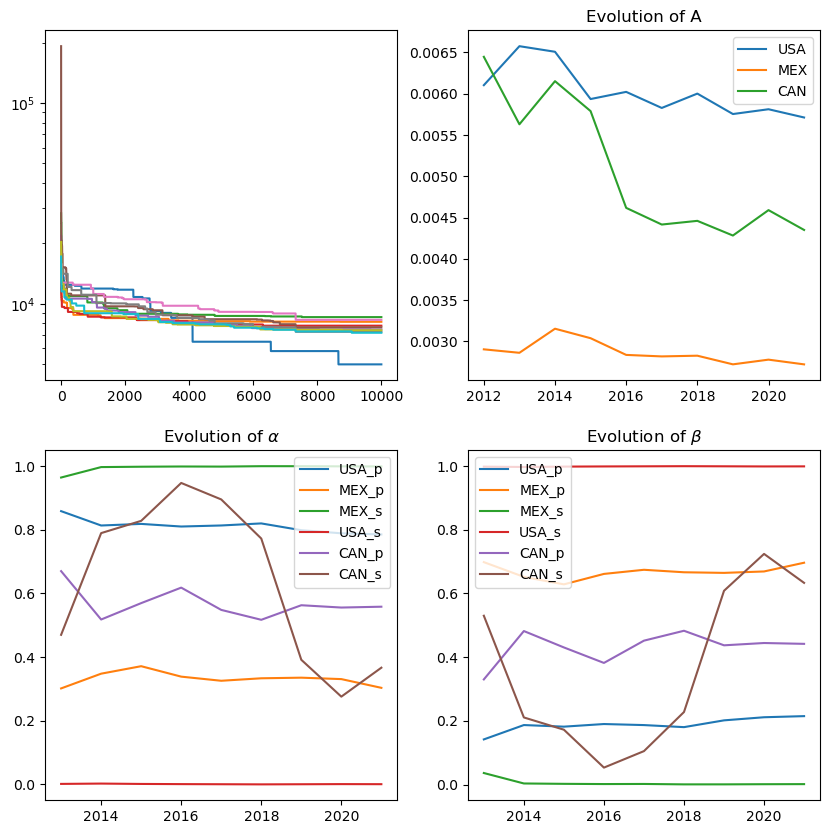

In [12]:
# Plot optimisation over the years [2000-2007, 2021]
import pickle
import matplotlib.pyplot as plt
import pandas as pd

range_years = range(2012,2022)
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
A_01=[]
A_11=[]
A_21=[]
alpha_01 = []
alpha_02 = []
alpha_11 = []
alpha_12 = []
alpha_21 = []
alpha_22 = []

beta_01 = []
beta_02 = []
beta_11 = []
beta_12 = []
beta_21 = []
beta_22 = []


for year in range_years:
    with open('/rds/general/user/nk821/home/anaconda3/CCS/ABM/Gulden/vectorised_tests/IO_mats/jobs/opt_results/optimization_results_{}.pkl'.format(year), 'rb') as f:
                    opt_result= pickle.load(f)

    with open('/rds/general/user/nk821/home/anaconda3/CCS/ABM/Gulden/vectorised_tests/IO_mats/jobs/best_A/best_A_matrices_{}.pkl'.format(year), 'rb') as f:
                    best_A_matrices= pickle.load(f)

    with open('/rds/general/user/nk821/home/anaconda3/CCS/ABM/Gulden/vectorised_tests/IO_mats/jobs/best_alpha/best_alpha_matrices_{}.pkl'.format(year), 'rb') as f:
                    best_alpha_matrices= pickle.load(f)

    with open('/rds/general/user/nk821/home/anaconda3/CCS/ABM/Gulden/vectorised_tests/IO_mats/jobs/best_beta/best_beta_matrices_{}.pkl'.format(year), 'rb') as f:
                    best_beta_matrices= pickle.load(f)

    
    ax[0,0].plot(opt_result['NGOpt'], label='{}'.format(year))
    
    A_01.append(best_A_matrices['NGOpt'][0,1])
    alpha_01.append(best_alpha_matrices['NGOpt'][0,1])
    alpha_02.append(best_alpha_matrices['NGOpt'][0,2])
    beta_01.append(best_beta_matrices['NGOpt'][0,1])
    beta_02.append(best_beta_matrices['NGOpt'][0,2])
#     A_02.append(best_A_matrices['NGOpt'][0,2])
    A_11.append(best_A_matrices['NGOpt'][1,1])
    alpha_11.append(best_alpha_matrices['NGOpt'][1,1])
    alpha_12.append(best_alpha_matrices['NGOpt'][1,2])
    beta_11.append(best_beta_matrices['NGOpt'][1,1])
    beta_12.append(best_beta_matrices['NGOpt'][1,2])
#     A_12.append(best_A_matrices['NGOpt'][1,2])
    
    A_21.append(best_A_matrices['NGOpt'][2,1])
    alpha_21.append(best_alpha_matrices['NGOpt'][2,1])
    alpha_22.append(best_alpha_matrices['NGOpt'][2,2])
    beta_21.append(best_beta_matrices['NGOpt'][2,1])
    beta_22.append(best_beta_matrices['NGOpt'][2,2])
#     A_22.append(best_A_matrices['NGOpt'][2,2])
    
    
    
ax[0,0].set_yscale('log')
ax[0,1].plot(range_years, A_01, label='USA')
# ax[1].plot(range_years, A_02, label='USA_s')
ax[0,1].plot(range_years, A_11, label='MEX')
# ax[1].plot(range_years, A_12, label='MEX_s')
ax[0,1].plot(range_years, A_21, label='CAN')
ax[0,1].set_title('Evolution of A')
# ax[1].plot(range_years, A_01, label='USA_p')
ax[0,1].legend()

ax[1,0].plot(range_years, pd.Series(alpha_01).rolling(window=2).mean(), label='USA_p')
ax[1,0].plot(range_years, pd.Series(alpha_11).rolling(window=2).mean(), label='MEX_p')
ax[1,0].plot(range_years, pd.Series(alpha_12).rolling(window=2).mean(), label='MEX_s')
ax[1,0].plot(range_years, pd.Series(alpha_02).rolling(window=2).mean(), label='USA_s')
ax[1,0].plot(range_years, pd.Series(alpha_21).rolling(window=2).mean(), label='CAN_p')
ax[1,0].plot(range_years, pd.Series(alpha_22).rolling(window=2).mean(), label='CAN_s')
ax[1,0].set_title(r'Evolution of $\alpha$')
ax[1,0].legend()

ax[1,1].plot(range_years, pd.Series(beta_01).rolling(window=2).mean(), label='USA_p')
ax[1,1].plot(range_years, pd.Series(beta_11).rolling(window=2).mean(), label='MEX_p')
ax[1,1].plot(range_years, pd.Series(beta_12).rolling(window=2).mean(), label='MEX_s')
ax[1,1].plot(range_years, pd.Series(beta_02).rolling(window=2).mean(), label='USA_s')
ax[1,1].plot(range_years, pd.Series(beta_21).rolling(window=2).mean(), label='CAN_p')
ax[1,1].plot(range_years, pd.Series(beta_22).rolling(window=2).mean(), label='CAN_s')
ax[1,1].set_title(r'Evolution of $\beta$')
ax[1,1].legend()
plt.show()
    


In [3]:
opt_result['NGOpt']

[17191.849187180895,
 13066.815019622114,
 13066.815019622114,
 13066.815019622114,
 13066.815019622114,
 13066.815019622114,
 13066.815019622114,
 13066.815019622114,
 13066.815019622114,
 11521.794677701668,
 11521.794677701668,
 11521.794677701668,
 11521.794677701668,
 11521.794677701668,
 11521.794677701668,
 11521.794677701668,
 11521.794677701668,
 11521.794677701668,
 11521.794677701668,
 11521.794677701668,
 11521.794677701668,
 11521.794677701668,
 11521.794677701668,
 11521.794677701668,
 11521.794677701668,
 11521.794677701668,
 11521.794677701668,
 11521.794677701668,
 11521.794677701668,
 11521.794677701668,
 11521.794677701668,
 11521.794677701668,
 11521.794677701668,
 11521.794677701668,
 11521.794677701668,
 11521.794677701668,
 11521.794677701668,
 11521.794677701668,
 11521.794677701668,
 11521.794677701668,
 11521.794677701668,
 11521.794677701668,
 11521.794677701668,
 11521.794677701668,
 11521.794677701668,
 11521.794677701668,
 11521.794677701668,
 11521.794677

In [7]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
from scipy.optimize import differential_evolution
import scipy.stats as stats
import matplotlib.pyplot as plt
from tqdm import tqdm
import os, sys, time, random, pickle
# import nevergrad as ng
from functions import production_function, regularise, wage_function, demand_function, innovate, generate_nested_matrix, visualize_multi_layer_trade_network, array_to_dataframe
from tradeutils import doAllTrades
from pricing import updatePricesAndConsume
from agents_vec import gulden_vectorised
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
corrs = []
for year in range_years:
    target_data = pd.read_csv('IO_mats/Data/TY_USMC_{}.csv'.format(year), index_col=[1, 2]).iloc[:,1:]
    target = target_data*1e-6

    best_A = best_A_matrices['NGOpt']
    best_alpha = best_alpha_matrices['NGOpt']
    best_beta = best_beta_matrices['NGOpt']


    Q, income, net_exports, io_df, io_df2, io_dfval, io_df2val = gulden_vectorised(
                case='test_3', n_countries=3, n_products=3, countries=['0', '1', '2'],
                products=['0', '1', '2'], citizens_per_nation=[870, 330, 100], A=best_A,
                alpha=best_alpha, beta=best_beta, share=np.ones(3),
                shock=None, shock_time=10000, iterations=1000, Tr_time=1, cm_time=1,
                trade_change=0.01, autarky_time=15000, pricing_algorithm='cpmu',
                utility_algorithm='geometric', wage_algorithm='marginal_product',
                csv=False, plot=False)
    corrs.append(np.corrcoef(io_df2val.stack().values, target.stack().values )[0,1])

plt.plot(range_years, corrs)
plt.xlabels('Years')
plt.ylabels('Correlation Coefficient')
plt.show()
    




/rds/general/user/nk821/home/anaconda3/envs/networks/lib/python3.10/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.26.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
100%|██████████| 1000/1000 [00:07<00:00, 133.20it/s]


ValueError: too many values to unpack (expected 7)

In [ ]:
Q, income, net_exports, io_df, io_df2, io_dfval, io_df2val = gulden_vectorised(
                case='test_3', n_countries=3, n_products=3, countries=['0', '1', '2'],
                products=['0', '1', '2'], citizens_per_nation=[870, 330, 100], A=best_A,
                alpha=best_alpha, beta=best_beta, share=np.ones(3),
                shock=None, shock_time=10000, iterations=1000, Tr_time=1, cm_time=1,
                trade_change=0.01, autarky_time=15000, pricing_algorithm='cpmu',
                utility_algorithm='geometric', wage_algorithm='marginal_product',
                csv=False, plot=True)

In [36]:
print('Correlation:', np.corrcoef(io_df2val.stack().values, target.stack().values )[0,1])

Correlation: 0.9940191987841014


In [ ]:
# Plot A - timeseries over time [2000-2007, 2021]


In [1]:
# Plot alpha - timeseries over time 


In [2]:
# Plot beta - timeseries over time


In [ ]:
# Plot Correlations over the years
# Multi-layered Network visualisation
# Net-exports Matrix - Fitness-complexity Framework

